In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

In [3]:
# load the whole size dataset
X = np.load("Aal/X_all.npy")
Y_NO2 = np.load("Aal/Y_NO2_all.npy")
Y_NOx = np.load("Aal/Y_NOx_all.npy")

In [4]:
# calculate the symmetric mean absolute percentage error (SMAPE)
# def get_score(pred, valid_y_exp):
#     return np.mean(np.abs(pred - valid_y_exp) / (pred + valid_y_exp) * 2)
def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)

# def get_score(valid_y_exp, pred):
#     return np.mean(2 * np.abs(valid_y_exp - pred)
#                          / (np.abs(pred) + np.abs(valid_y_exp)) , axis=-1)

                        

In [5]:
listfeature_name = ['NOx_Concentration','NO2_Concentration', # feature 0-1
            'temperature','pressure','humidity','wind_speed', 'wind_direction', # feature 2-6
            'holiday','time_month','time_week','time_day','time_hour','station_index', # feature 7-12
            
            'mean_NOx','mean_NO2','mean_temperature','mean_pressure','mean_humidity','mean_wind_speed','mean_wind_direction', # feature 13-19
            'max_NOx','max_NO2','max_temperature','max_pressure','max_humidity','max_wind_speed', # feature 20-26

            'var_NOx','var_NO2','var_temperature','var_pressure','var_humidity','var_wind_speed','var_wind_direction', # feature 27-33 hmmm two wind speed wonder if it should be directions
            'pressure_temperature','temperature_humidity','NO2*NOx','NO2_NOx',

            'NOx_0','NOx_1','NOx_2','NOx_3','NOx_4','NOx_5','NOx_6','NOx_7','NOx_8','NOx_9','NOx_10','NOx_11', # feature 37-48 historical NOx 

            'NO2_0','NO2_1','NO2_2','NO2_3','NO2_4','NO2_5','NO2_6','NO2_7','NO2_8','NO2_9','NO2_10','NO2_11', # feature 49-60 historical NO2 features
            'HTFF_0','HTFF_1','HTFF_2','HTFF_3','HTFF_4','HTFF_5','HTFF_6','HTFF_7','HTFF_8','HTFF_9','HTFF_10','HTFF_11','HTFF_12',

            'HTFF_13','HTFF_14','HTFF_15','HTFF_16','HTFF_17','HTFF_18','HTFF_19','HTFF_20','HTFF_21','HTFF_22','HTFF_23', # feature 61-84 historical temperature and forecasting features
            'HPFF_0','HPFF_1','HPFF_2','HPFF_3','HPFF_4','HPFF_5','HPFF_6','HPFF_7','HPFF_8','HPFF_9','HPFF_10','HPFF_11','HPFF_12',

            'HPFF_13','HPFF_14','HPFF_15','HPFF_16','HPFF_17','HPFF_18','HPFF_19','HPFF_20','HPFF_21','HPFF_22','HPFF_23', # feature 85-108 historical pressure and forecasting features
            'HHFF_0','HHFF_1','HHFF_2','HHFF_3','HHFF_4','HHFF_5','HHFF_6','HHFF_7','HHFF_8','HHFF_9','HHFF_10','HHFF_11','HHFF_12',

            'HHFF_13','HHFF_14','HHFF_15','HHFF_16','HHFF_17','HHFF_18','HHFF_19','HHFF_20','HHFF_21','HHFF_22','HHFF_23',  # feature 109-132 historical humidity and forecasting features
            'HWSFF_0','HWSFF_1','HWSFF_2','HWSFF_3','HWSFF_4','HWSFF_5','HWSFF_6','HWSFF_7','HWSFF_8','HWSFF_9','HWSFF_10','HWSFF_11','HWSFF_12',

            'HWSFF_13','HWSFF_14','HWSFF_15','HWSFF_16','HWSFF_17','HWSFF_18','HWSFF_19','HWSFF_20','HWSFF_21','HWSFF_22','HWSFF_23', # feature 133-156 historical wind_speed and forecasting features
            'HWDFF_0','HWDFF_1','HWDFF_2','HWDFF_3','HWDFF_4','HWDFF_5','HWDFF_6','HWDFF_7','HWDFF_8','HWDFF_9','HWDFF_10','HWDFF_11','HWDFF_12',
            
            'HWDFF_13','HWDFF_14','HWDFF_15','HWDFF_16','HWDFF_17','HWDFF_18','HWDFF_19','HWDFF_20','HWDFF_21','HWDFF_22','HWDFF_23', # feature 157-180 historical wind_direction and forecasting features
            "prediction_id"  # feature 181: prediction id
            
            
           
            ]

In [11]:
# lightgbm model parameters
# model_param = {'lr': 0.02, 'depth': 10, 'tree': 3000, 'leaf': 400, 'sample': 0.9, 'seed': 3}

# model_param = {'lr': 0.1, 'depth': 10, 'tree': 300, 'leaf': 600, 'sample': 0.8, 'seed': 3}

# train and test the input X Y with the lightgbm model
def train_test(model_param, train_X, test_X, train_Y, test_Y, save_dir,lgb_train,lgb_eval):
    time_start = time.time()
    #lgb_train = lgb.Dataset(train_X, train_Y)
    #lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    
    params = {
    'task': 'train',
    'verbosity': -1,
    'gpu_use_dp': True,
    'device_type': 'gpu',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'max_depth': model_param['depth'], #impact on model performance and train time
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    #'num_threads':7
    # 'feature_fraction': 1, #can be used to speed up training and deal with overfitting
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 1,
    # 'bagging_seed': 3,
#     'min_sum_hessian_in_leaf': 100,
    }
    evaluation_results  = {}

    gbm = lgb.train(params,
                    train_set = lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['Train', 'Valid'],
                    #evals_result= evaluation_results,
                    #verbose_eval=500,
                    #early_stopping_rounds=3,
                    feature_name = listfeature_name,
                    callbacks=[lgb.early_stopping(stopping_rounds=3),lgb.log_evaluation(period=500),lgb.record_evaluation(eval_result=evaluation_results)]) 

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)

    #lgb.plot_metric(evaluation_results)
    return score

In [7]:
# split the Y_PM25, X into training part and testing part
train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx = train_test_split(X, Y_NOx, test_size=0.2)
print(train_X_NOx.shape, test_X_NOx.shape, train_Y_NOx.shape, test_Y_NOx.shape)


(803635, 182) (200909, 182) (803635,) (200909,)


In [13]:
listofmodel = []
model_param = {'lr': 0.1, 'depth': 1, 'tree': 3000, 'leaf': 2**1,"num_iterations":1}
model_param["score"] = 5
listofmodel.append(model_param)
print(listofmodel)
#jacob 500 leaf

[{'lr': 0.1, 'depth': 1, 'tree': 3000, 'leaf': 2, 'score': 5}]


In [12]:
listofmodel = []
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_NOx_test.npy")
lgb_train = lgb.Dataset(train_X_NOx, train_Y_NOx)
lgb_eval = lgb.Dataset(test_X_NOx, test_Y_NOx, reference=lgb_train)
for i in range(22,23): #35
    for j in range(10,11):
        model_param = {'lr': 0.1, 'depth': i, 'tree': 6000, 'leaf': 2**j}
        score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "Aal/lgbm/lightgbm_NOx_1.model",lgb_train,lgb_eval)
        model_param["i"]=i
        model_param["j"]=j
        model_param["score"] = score
        gbm = read_pkl("Aal/lgbm/lightgbm_NOx_1.model")
        test_predict = gbm.predict(test_X)
        test_score = get_score(test_predict, test_Y)
        test_score48 = get_score(test_predict[0:48],test_Y[0:48])
        model_param["test_score"]=test_score
        model_param["test_score48"]=test_score48
        listofmodel.append(model_param)

print(listofmodel)

Training until validation scores don't improve for 3 rounds
[500]	Train's l1: 1.62434	Valid's l1: 2.42104
[1000]	Train's l1: 1.30789	Valid's l1: 2.28941
[1500]	Train's l1: 1.11099	Valid's l1: 2.2115
[2000]	Train's l1: 1.05117	Valid's l1: 2.19396
[2500]	Train's l1: 0.998738	Valid's l1: 2.17403
[3000]	Train's l1: 0.966119	Valid's l1: 2.16261
[3500]	Train's l1: 0.946164	Valid's l1: 2.15702
Early stopping, best iteration is:
[3996]	Train's l1: 0.932853	Valid's l1: 2.15273
running time:  1274.3339667320251
Training until validation scores don't improve for 3 rounds
[500]	Train's l1: 1.63683	Valid's l1: 2.43997
[1000]	Train's l1: 1.26991	Valid's l1: 2.27817
[1500]	Train's l1: 1.09424	Valid's l1: 2.22129
[2000]	Train's l1: 1.05501	Valid's l1: 2.20876
Early stopping, best iteration is:
[2170]	Train's l1: 1.03881	Valid's l1: 2.206
running time:  687.0446527004242
Training until validation scores don't improve for 3 rounds
[500]	Train's l1: 1.65588	Valid's l1: 2.44396
[1000]	Train's l1: 1.31769	

Training until validation scores don't improve for 3 rounds
[10]	Train's l1: 6.51444	Valid's l1: 6.66757
[20]	Train's l1: 4.42706	Valid's l1: 4.69984
[30]	Train's l1: 3.7026	Valid's l1: 4.0456
[40]	Train's l1: 3.33914	Valid's l1: 3.72723
[50]	Train's l1: 3.15587	Valid's l1: 3.56576
[60]	Train's l1: 3.05402	Valid's l1: 3.47851
[70]	Train's l1: 2.96057	Valid's l1: 3.40484
[80]	Train's l1: 2.82977	Valid's l1: 3.30956
[90]	Train's l1: 2.70351	Valid's l1: 3.21684
[100]	Train's l1: 2.61048	Valid's l1: 3.15125
[110]	Train's l1: 2.52709	Valid's l1: 3.0935
[120]	Train's l1: 2.4473	Valid's l1: 3.04105
[130]	Train's l1: 2.38389	Valid's l1: 3.00027
[140]	Train's l1: 2.33016	Valid's l1: 2.96528
[150]	Train's l1: 2.29043	Valid's l1: 2.9412
[160]	Train's l1: 2.26383	Valid's l1: 2.92408
[170]	Train's l1: 2.2247	Valid's l1: 2.89994
[180]	Train's l1: 2.19544	Valid's l1: 2.88245
[190]	Train's l1: 2.16737	Valid's l1: 2.86497
[200]	Train's l1: 2.14699	Valid's l1: 2.85299
[210]	Train's l1: 2.1282	Valid's l1

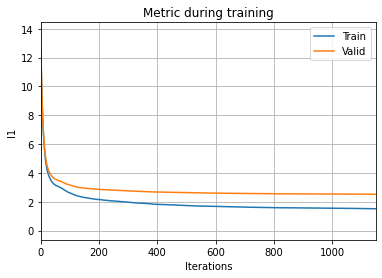

In [24]:
{'lr': 0.1, 'depth': 14, 'tree': 3000, 'leaf': 1024, 'i': 14, 'j': 10, 'score': 2.450850876002856, 'test_score': 2.538154787903864}
score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "Aal/lightgbm_NOx_1.model",lgb_train,lgb_eval)
print('score: ', score)

In [10]:
gbm = read_pkl("Aal/lightgbm_NOx_1.model")
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_NOx_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

2.9285148938529026

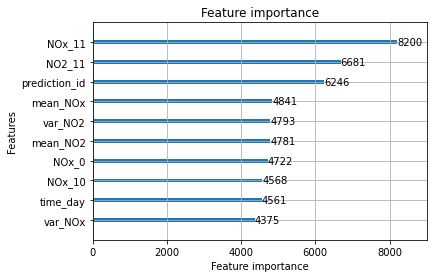

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pack

Training until validation scores don't improve for 15 rounds
[10]	Train's l1: 10.3395	Valid's l1: 10.4026
[20]	Train's l1: 7.85946	Valid's l1: 7.91473
[30]	Train's l1: 6.55648	Valid's l1: 6.60915
[40]	Train's l1: 5.85971	Valid's l1: 5.90806
[50]	Train's l1: 5.48705	Valid's l1: 5.53134
[60]	Train's l1: 5.24889	Valid's l1: 5.28987
[70]	Train's l1: 5.09598	Valid's l1: 5.13497
[80]	Train's l1: 4.9897	Valid's l1: 5.02781
[90]	Train's l1: 4.89729	Valid's l1: 4.93646
[100]	Train's l1: 4.81541	Valid's l1: 4.85737
[110]	Train's l1: 4.75875	Valid's l1: 4.80284
[120]	Train's l1: 4.69773	Valid's l1: 4.74525
[130]	Train's l1: 4.6508	Valid's l1: 4.70094
[140]	Train's l1: 4.5971	Valid's l1: 4.65057
[150]	Train's l1: 4.53784	Valid's l1: 4.5944
[160]	Train's l1: 4.48923	Valid's l1: 4.54795
[170]	Train's l1: 4.44304	Valid's l1: 4.50509
[180]	Train's l1: 4.39669	Valid's l1: 4.46092
[190]	Train's l1: 4.3445	Valid's l1: 4.41178
[200]	Train's l1: 4.31401	Valid's l1: 4.38321
[210]	Train's l1: 4.29379	Valid's

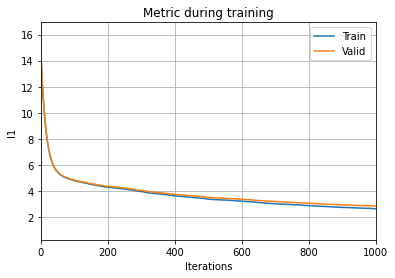

In [ ]:
model_param = {'lr': 0.05, 'depth': 64, 'tree': 1000, 'leaf': 48}
score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "Aal/lightgbm_NOx.model")
print('score: ', score)

In [ ]:
gbm = read_pkl("Aal/lightgbm_NOx.model")
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_NOx_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

6.4493424250739775

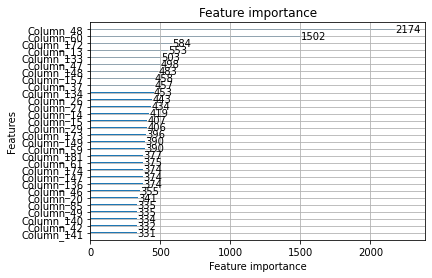

"\nfeatures = ['PM25_Concentration','PM10_Concentration','NO2_Concentration', # feature 0-2\n            'temperature','pressure','humidity','wind_speed', 'wind_direction', # feature 3-7\n            'holiday','time_month','time_week','time_day','time_hour','station_index', # feature 8-13\n            \n            'mean_PM25','mean_PM10','mean_NO2','mean_temperature','mean_pressure','mean_humidity','mean_wind_speed','mean_wind_direction', # feature 14-21\n            'max_PM25','max_PM10','max_NO2','max_temperature','max_pressure','max_humidity','max_wind_speed', # feature 22-28\n            'var_PM25','var_PM10','var_NO2','var_temperature','var_pressure','var_humidity','var_wind_speed','var_wind_speed', # feature 29-36\n            'pressure_temperature','temperature_humidity','PM','PM25_10' # feature 37-40\n            \n            # feature 41-52: historical PM2.5 features\n            # feature 53-64: historical PM10 features\n            # feature 65-76: historical NO2 features\

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()
'''
features = ['PM25_Concentration','PM10_Concentration','NO2_Concentration', # feature 0-2
            'temperature','pressure','humidity','wind_speed', 'wind_direction', # feature 3-7
            'holiday','time_month','time_week','time_day','time_hour','station_index', # feature 8-13
            
            'mean_PM25','mean_PM10','mean_NO2','mean_temperature','mean_pressure','mean_humidity','mean_wind_speed','mean_wind_direction', # feature 14-21
            'max_PM25','max_PM10','max_NO2','max_temperature','max_pressure','max_humidity','max_wind_speed', # feature 22-28
            'var_PM25','var_PM10','var_NO2','var_temperature','var_pressure','var_humidity','var_wind_speed','var_wind_speed', # feature 29-36
            'pressure_temperature','temperature_humidity','PM','PM25_10' # feature 37-40
            
            # feature 41-52: historical PM2.5 features
            # feature 53-64: historical PM10 features
            # feature 65-76: historical NO2 features
            # feature 77-100: historical temperature and forecasting features
            # feature 101-124: historical pressure and forecasting features
            # feature 125-148: historical humidity and forecasting features
            # feature 149-172: historical wind_speed and forecasting features
            # feature 173-196: historical wind_direction and forecasting features
            
            # feature 197: prediction id
            ]
'''

In [ ]:
# PM 10

In [ ]:
# split the Y_PM10, X into training part and testing part

train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10 = train_test_split(X, Y_PM10, test_size=0.2, random_state=11)
print(train_X_PM10.shape, test_X_PM10.shape, train_Y_PM10.shape, test_Y_PM10.shape)

NameError: name 'Y_PM10' is not defined

In [ ]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model
model_param = {'lr': 0.01, 'depth': 10, 'tree': 1000, 'leaf': 600, 'sample': 0.8, 'seed': 3}

score = train_test(model_param, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10.model")
print('score: ', score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.847149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l1: 9.97568	valid_0's l2: 204.148
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 9.90216	valid_0's l2: 201.245
[3]	valid_0's l1: 9.82956	valid_0's l2: 198.408
[4]	valid_0's l1: 9.75777	valid_0's l2: 195.622
[5]	valid_0's l1: 9.68695	valid_0's l2: 192.893
[6]	valid_0's l1: 9.61697	valid_0's l2: 190.216
[7]	valid_0's l1: 9.54787	valid_0's l2: 187.592
[8]	valid_0's l1: 9.4795	valid_0's l2: 185.013
[9]	valid_0's l1: 9.412	valid_0's l2: 182.49
[10]	valid_0's l1: 9.3453	valid_0's l2: 180.017
[11]	valid_0's l1: 9.27939	valid_0's l2: 177.589
[12]	valid_0's l1: 9.21432	valid_0's l2: 175.207
[13]	valid_0's l1: 9.15009	valid_0's l2: 172.872
[14]	valid_0's l1: 9.08661	valid_0's l2: 170.582
[15]	valid_0's l1: 9.02397	valid_0's l2: 168.34
[16]	valid_0's l1: 8.96207	valid_0's l2: 166.14
[17]	v

In [ ]:
gbm = read_pkl("London/lightgbm_PM10.model")
test_X = np.load("London/X_test.npy")
test_Y = np.load("London/Y_PM10_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.3010808596627848

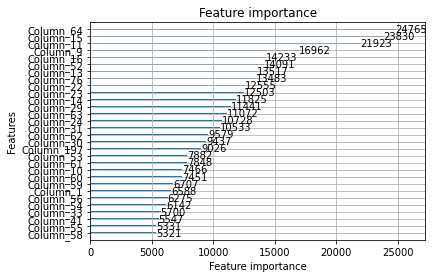

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [ ]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model
model_param = {'lr': 0.005, 'depth': 10, 'tree': 1000, 'leaf': 600, 'sample': 0.8, 'seed': 3}

score = train_test(model_param, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10_1.model")
print('score: ', score)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.876912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l1: 10.0128	valid_0's l2: 205.624
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 9.97584	valid_0's l2: 204.154
[3]	valid_0's l1: 9.93908	valid_0's l2: 202.703
[4]	valid_0's l1: 9.90252	valid_0's l2: 201.263
[5]	valid_0's l1: 9.86621	valid_0's l2: 199.839
[6]	valid_0's l1: 9.83011	valid_0's l2: 198.429
[7]	valid_0's l1: 9.79423	valid_0's l2: 197.035
[8]	valid_0's l1: 9.75856	valid_0's l2: 195.65
[9]	valid_0's l1: 9.7231	valid_0's l2: 194.284
[10]	valid_0's l1: 9.68786	valid_0's l2: 192.93
[11]	valid_0's l1: 9.65285	valid_0's l2: 191.589
[12]	valid_0's l1: 9.61804	valid_0's l2: 190.257
[13]	valid_0's l1: 9.58344	valid_0's l2: 188.943
[14]	valid_0's l1: 9.54904	valid_0's l2: 187.639
[15]	valid_0's l1: 9.51485	valid_0's

In [ ]:
gbm = read_pkl("London/lightgbm_PM10_1.model")
# test_X = np.load("London/X_test.npy")
# test_Y = np.load("London/Y_PM10_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.29485384349933497

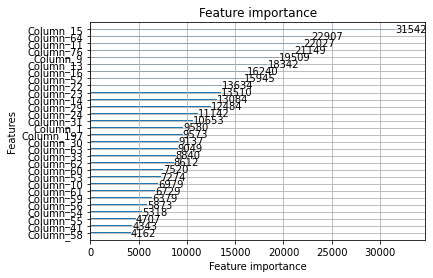

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [ ]:
# train and test the lightgbm model with X and Y_PM10 data
# save the model parameters into lightgbm_PM10.model
model_param = {'lr': 0.005, 'depth': 10, 'tree': 2000, 'leaf': 600, 'sample': 0.8, 'seed': 3}

score = train_test(model_param, train_X_PM10, test_X_PM10, train_Y_PM10, test_Y_PM10, "London/lightgbm_PM10_2.model")
print('score: ', score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.049286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l1: 10.0128	valid_0's l2: 205.624
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l1: 9.97584	valid_0's l2: 204.154
[3]	valid_0's l1: 9.93908	valid_0's l2: 202.703
[4]	valid_0's l1: 9.90252	valid_0's l2: 201.263
[5]	valid_0's l1: 9.86621	valid_0's l2: 199.839
[6]	valid_0's l1: 9.83011	valid_0's l2: 198.429
[7]	valid_0's l1: 9.79423	valid_0's l2: 197.035
[8]	valid_0's l1: 9.75856	valid_0's l2: 195.65
[9]	valid_0's l1: 9.7231	valid_0's l2: 194.284
[10]	valid_0's l1: 9.68786	valid_0's l2: 192.93
[11]	valid_0's l1: 9.65285	valid_0's l2: 191.589
[12]	valid_0's l1: 9.61804	valid_0's l2: 190.257
[13]	valid_0's l1: 9.58344	valid_0's l2: 188.943
[14]	valid_0's l1: 9.54904	valid_0's l2: 187.639
[15]	valid_0's l1: 9.51485	valid_0's l2: 186.349
[16]	valid_0's l1: 9.48087	valid_0's l2: 185.071
[1

In [ ]:
gbm = read_pkl("London/lightgbm_PM10_2.model")
# test_X = np.load("London/X_test.npy")
# test_Y = np.load("London/Y_PM10_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.30246981019173264

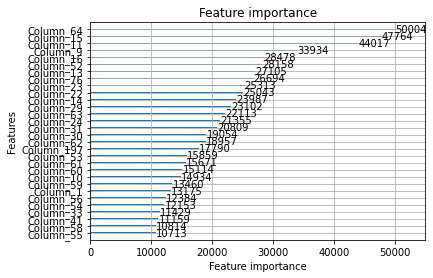

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()

In [ ]:
# NO2

In [ ]:
# split the Y_NO2, X into training part and testing part

train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2, random_state=11)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(665395, 182) (166349, 182) (665395,) (166349,)


In [ ]:
model_param = {'lr': 0.005, 'depth': 10, 'tree': 1000, 'leaf': 600, 'sample': 0.8, 'seed': 3}

score = train_test(model_param, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "Aal/lightgbm_NO2_1.model")
print('score: ', score)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 92.4995	valid_0's l1: 7.265
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 91.7531	valid_0's l1: 7.23516
[3]	valid_0's l2: 91.0141	valid_0's l1: 7.20551
[4]	valid_0's l2: 90.2825	valid_0's l1: 7.17605
[5]	valid_0's l2: 89.5584	valid_0's l1: 7.14676
[6]	valid_0's l2: 88.8422	valid_0's l1: 7.11765
[7]	valid_0's l2: 88.1321	valid_0's l1: 7.08868
[8]	valid_0's l2: 87.4284	valid_0's l1: 7.05984
[9]	valid_0's l2: 86.7312	valid_0's l1: 7.03117
[10]	valid_0's l2: 86.0416	valid_0's l1: 7.00266
[11]	valid_0's l2: 85.3592	valid_0's l1: 6.97433
[12]	valid_0's l2: 84.6844	valid_0's l1: 6.94624
[13]	valid_0's l2: 84.0144	valid_0's l1: 6.91824
[14]	valid_0's l2: 83.3497	valid_0's l1: 6.89032
[15]	valid_0's l2: 82.6935	valid_0'

In [ ]:
gbm = read_pkl("Aal/lightgbm_NO2_1.model")
test_X = np.load("Aal/X_test.npy")
test_Y = np.load("Aal/Y_NO2_test.npy")
test_predict = gbm.predict(test_X)
score = get_score(test_predict, test_Y)
score

0.3266873366398986

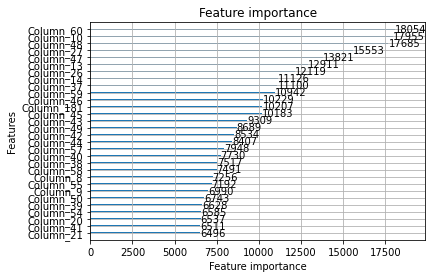

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
ax = lgb.plot_importance(gbm, max_num_features=30)
plt.show()